# Multi Pelvis and Fetus Landmark Segmentation Testing 🐣

In [34]:

from google.colab import drive
drive.mount('/content/drive')

!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import numpy as np
from scipy.ndimage import zoom
import nibabel as nib

import skimage
import matplotlib.pyplot as plt

from scipy import ndimage
from skimage.measure import label, regionprops

import sys
import os

import torch
import monai
from monai.inferers import sliding_window_inference
from monai.networks.nets import DenseNet121, UNet, AttentionUnet

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


In [36]:
root_dir='/content/drive/MyDrive/BEng_Project2/NEW/running-pelvis-and-fetus-landmarks'
print(root_dir)
os.chdir(root_dir)

/content/drive/MyDrive/BEng_Project2/NEW/running-pelvis-and-fetus-landmarks


## Loading and rescaling patient's MRI image 🩻

In [122]:
# test nii image to create input test image matrix

subject = 'mibirth019301'

In [124]:

# Loading T2-weighted MRI .nii.gz file
input_img_name='training-fetus-042025/'+ subject +'-t2.nii.gz'
global_img = nib.load(input_img_name)

# Extracting the raw 3D data into a NumPy array
input_matrix_image_data = global_img.get_fdata()


#  dimensions and voxel spacing
print("T2w image: shape =", global_img.shape, ", voxel spacing =", global_img.header.get_zooms(), "mm")
print()
# spacial orientation matrix
print("T2w image: image to world affine orientation =")
print(global_img.affine)

max_intensity = np.max(input_matrix_image_data)
min_intensity = np.min(input_matrix_image_data)

print("Maximum intensity:", max_intensity)
print("Minimum intensity:", min_intensity)


T2w image: shape = (128, 128, 128) , voxel spacing = (np.float32(2.639414), np.float32(2.639414), np.float32(2.639414)) mm

T2w image: image to world affine orientation =
[[-3.71394027e-08 -2.63914054e+00  3.79982212e-02  1.57091553e+02]
 [-1.25304444e-02  3.79977931e-02  2.63911080e+00 -1.23506493e+02]
 [-2.63938433e+00 -1.80356916e-04 -1.25291463e-02  1.50893936e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Maximum intensity: 742.0
Minimum intensity: 0.0


(128, 128, 128)


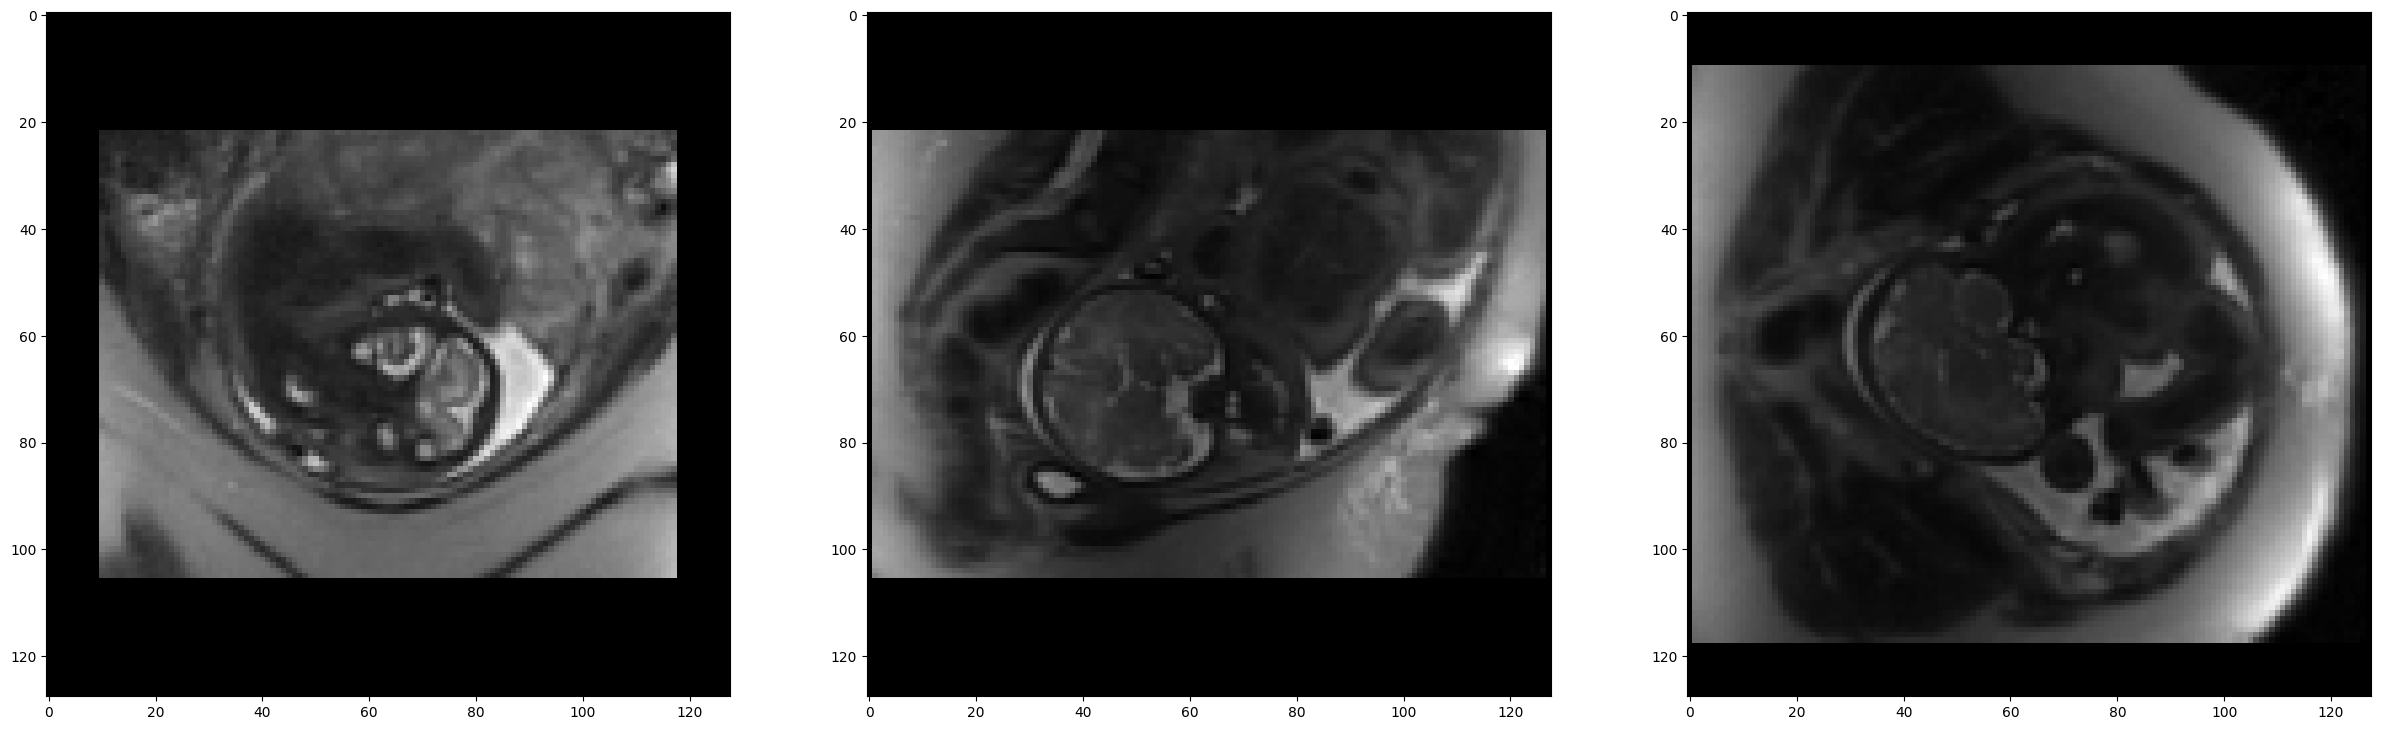

In [125]:

# visualise original image for testing purposes - it is isotropic

x,y,z=input_matrix_image_data.shape

print(input_matrix_image_data.shape)

plt.figure("image", (30, 10))
plt.subplot(1, 3, 1)
plt.imshow(input_matrix_image_data[:, :, round(z/2)], cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(input_matrix_image_data[:, round(y/2), :], cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(input_matrix_image_data[round(x/2), :, :], cmap="gray")


In [126]:
# convert to tensor & apply transforms:

# Converting to a PyTorch tensor with a channel dimension
input_image = torch.tensor(input_matrix_image_data).unsqueeze(0)

# - scale to [0; 1]
scaler = monai.transforms.ScaleIntensity(minv=0.0, maxv=1.0)
final_image = scaler(input_image)


torch.Size([1, 128, 128, 128])
(128, 128, 128)


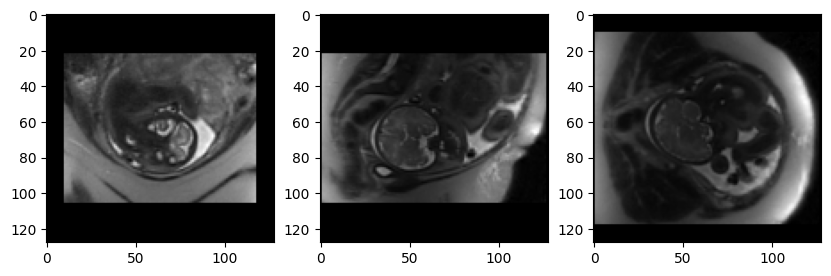

In [127]:

# visualise output for testing purposese - now it looks ok

image_matrix = final_image.cpu().numpy()[0, :, :, :]

print(input_image.shape)
print(image_matrix.shape)

s=64

plt.figure("image", (10, 30))
plt.subplot(1, 3, 1)
plt.imshow(image_matrix[:, :, s], cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(image_matrix[:, s, :], cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(image_matrix[s, :, :], cmap="gray")


## 1️⃣ Running the Pelvis Model 🐣

In [128]:

# note: modify paths to model

cl_num_pelvis = 20  # 9 labels for diff. pelvis regions + 11 landmarks

pelvis_model_weights_path_unet="unet_training_multipelvis_landmarks_62train_5val_20labels_v2_latest_metric_model.pth"


In [129]:

# define and load UNet model

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pelvis_model = UNet(spatial_dims=3,
                          in_channels=1,
                          out_channels=cl_num_pelvis+1,
                          channels=(32, 64, 128, 256, 512),
                          strides=(2,2,2,2),
                          kernel_size=3,
                          up_kernel_size=3,
                          num_res_units=1,
                          act='PRELU',
                          norm='INSTANCE',
                          dropout=0.5)

with torch.no_grad():
  pelvis_model.load_state_dict(torch.load(pelvis_model_weights_path_unet), strict=False)
  pelvis_model.to(device)
  pelvis_model.eval()


In [130]:

# run segmentation and argmax the labels

segmentation_inputs = final_image.unsqueeze(0).to(device)

with torch.no_grad():
    segmentation_output = pelvis_model(segmentation_inputs)

# Using the argmax across class channels to get final labels (assigns each voxel to the most probable class)
pelvis_label_output = torch.argmax(segmentation_output, dim=1).detach().cpu()[0, :, :, :]
pelvis_label_matrix = pelvis_label_output.cpu().numpy()


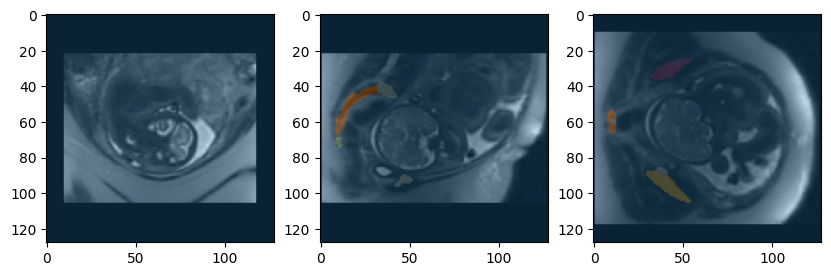

In [131]:

# visualise results for testing purposes (brain - 2, body - 1)

s=64
lab_num = 7

plt.figure("image", (10, 10))
plt.subplot(1, 3, 1)
plt.imshow(image_matrix[:, :, s], cmap="gray")
plt.imshow(pelvis_label_matrix[:, :, s], alpha = 0.3, cmap="tab20", vmin=0, vmax=lab_num)

plt.subplot(1, 3, 2)
plt.imshow(image_matrix[:, s, :], cmap="gray")
plt.imshow(pelvis_label_matrix[:, s, :], alpha = 0.3, cmap="tab20", vmin=0, vmax=lab_num)

plt.subplot(1, 3, 3)
plt.imshow(image_matrix[s, :, :], cmap="gray")
plt.imshow(pelvis_label_matrix[s, :, :], alpha = 0.3, cmap="tab20", vmin=0, vmax=lab_num)


In [132]:
# tranform to the original space and save label image

# Create output directory
res_dir = root_dir + "/" + "UNet_testing_results"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)

# Output filenames
pelvis_output_img_name= res_dir + '/resampled_' + subject + '-t2.nii.gz'
pelvis_output_lab_name= res_dir + '/resampled_' + subject + '-t2-pelvis_labels.nii.gz'


In [202]:
# Load original image for spatial metadata
img_tmp_info = nib.load(input_img_name)

# Save predicted label map
out_lab_nii = nib.Nifti1Image(pelvis_label_matrix, img_tmp_info.affine, img_tmp_info.header)
nib.save(out_lab_nii, pelvis_output_lab_name)

# Save input image (transformed version used in model)
out_img_nii = nib.Nifti1Image(image_matrix, img_tmp_info.affine, img_tmp_info.header)
nib.save(out_img_nii, pelvis_output_img_name)

## 2️⃣ Running the Fetal Model 🐤

In [136]:

# note: modify paths to model

cl_num_fetus = 11  # 9 labels for diff. pelvis regions + 11 landmarks

fetal_model_weights_path_unet="unet_training_fetus_and_landmarks_57orig57flip_train_10val_11labels_v4_latest_metric_model.pth"


In [137]:

# define and load UNet model

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fetal_model = UNet(spatial_dims=3,
                          in_channels=1,
                          out_channels=cl_num_fetus+1,
                          channels=(32, 64, 128, 256, 512),
                          strides=(2,2,2,2),
                          kernel_size=3,
                          up_kernel_size=3,
                          num_res_units=1,
                          act='PRELU',
                          norm='INSTANCE',
                          dropout=0.5)

with torch.no_grad():
  fetal_model.load_state_dict(torch.load(fetal_model_weights_path_unet), strict=False)
  fetal_model.to(device)
  fetal_model.eval()


In [138]:

# run segmentation and argmax the labels

segmentation_inputs = final_image.unsqueeze(0).to(device)

with torch.no_grad():
    segmentation_output = fetal_model(segmentation_inputs)

# Using the argmax across class channels to get final labels (assigns each voxel to the most probable class)
fetus_label_output = torch.argmax(segmentation_output, dim=1).detach().cpu()[0, :, :, :]
fetus_label_matrix = fetus_label_output.cpu().numpy()


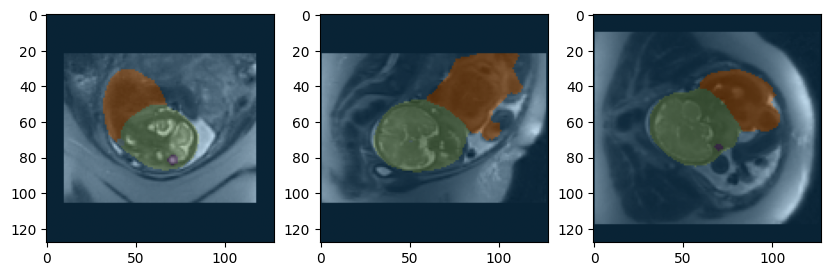

In [139]:

# visualise results for testing purposes (brain - 2, body - 1)

s=64
lab_num = 7

plt.figure("image", (10, 10))
plt.subplot(1, 3, 1)
plt.imshow(image_matrix[:, :, s], cmap="gray")
plt.imshow(fetus_label_matrix[:, :, s], alpha = 0.3, cmap="tab20", vmin=0, vmax=lab_num)

plt.subplot(1, 3, 2)
plt.imshow(image_matrix[:, s, :], cmap="gray")
plt.imshow(fetus_label_matrix[:, s, :], alpha = 0.3, cmap="tab20", vmin=0, vmax=lab_num)

plt.subplot(1, 3, 3)
plt.imshow(image_matrix[s, :, :], cmap="gray")
plt.imshow(fetus_label_matrix[s, :, :], alpha = 0.3, cmap="tab20", vmin=0, vmax=lab_num)


In [140]:
# tranform to the original space and save label image

# Create output directory
res_dir = root_dir + "/" + "UNet_testing_results"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)

# Output filenames
#pelvis_output_img_name= res_dir + '/resampled_' + subject + '-t2.nii.gz'
fetus_output_lab_name= res_dir + '/resampled_' + subject + '-t2-fetus_labels.nii.gz'


In [ ]:
# Load original image for spatial metadata
img_tmp_info = nib.load(input_img_name)

# Save predicted label map
out_lab_nii = nib.Nifti1Image(fetus_label_matrix, img_tmp_info.affine, img_tmp_info.header)
nib.save(out_lab_nii, fetus_output_lab_name)


## 3️⃣ Calculating Fetal Biometry 🐤

### Old fetal biometry function:

In [36]:
import numpy as np
import nibabel as nib
from scipy.ndimage import label, find_objects

def extract_two_largest_components(mask):
    # Label connected components
    labeled_mask, num_features = label(mask)
    if num_features < 2:
        return None, None  # Not enough components to compute paired distance

    component_sizes = [(i + 1, (labeled_mask == (i + 1)).sum()) for i in range(num_features)]
    component_sizes.sort(key=lambda x: x[1], reverse=True)
    first_label, second_label = component_sizes[0][0], component_sizes[1][0]

    first_coords = np.argwhere(labeled_mask == first_label)
    second_coords = np.argwhere(labeled_mask == second_label)

    return first_coords.mean(axis=0), second_coords.mean(axis=0)

def compute_fetal_biometry(landmarks_path):
    # Load the landmarks NIfTI file
    landmarks_img = nib.load(landmarks_path)
    landmarks_data = landmarks_img.get_fdata()
    affine = landmarks_img.affine

    # Dictionary to hold mm positions
    landmark_coords_mm = {}

    # Labels with single landmark (centroid-based)
    single_labels = {
        "OFD": (5, 6),
        "Mento-vertical diameter": (8, 9)
    }

    for name, (lm1, lm2) in single_labels.items():
        coords1 = np.argwhere(landmarks_data == lm1)
        coords2 = np.argwhere(landmarks_data == lm2)
        if coords1.size > 0 and coords2.size > 0:
            centroid1 = np.dot(affine, np.append(coords1.mean(axis=0), 1))[:3]
            centroid2 = np.dot(affine, np.append(coords2.mean(axis=0), 1))[:3]
            landmark_coords_mm[name] = np.linalg.norm(centroid1 - centroid2)
        else:
            landmark_coords_mm[name] = None

    # Labels with 2 paired spheres (use largest 2 connected components)
    paired_labels = {
        "BPD": 7,
        "Bihumeral diameter": 4
    }

    for name, label_val in paired_labels.items():
        mask = (landmarks_data == label_val)
        centroid1_voxel, centroid2_voxel = extract_two_largest_components(mask)
        if centroid1_voxel is not None and centroid2_voxel is not None:
            centroid1 = np.dot(affine, np.append(centroid1_voxel, 1))[:3]
            centroid2 = np.dot(affine, np.append(centroid2_voxel, 1))[:3]
            landmark_coords_mm[name] = np.linalg.norm(centroid1 - centroid2)
        else:
            landmark_coords_mm[name] = None

    # Print and return results
    for name, dist in landmark_coords_mm.items():
        if dist is not None:
            print(f"{name}: {dist:.2f} mm")
        else:
            print(f"{name}: Landmark(s) missing or incomplete")

    return landmark_coords_mm


In [37]:
# Calculating the distance between the landmarks segemnted by the model
landmarks_path = fetus_output_lab_name
biometry_results = compute_fetal_biometry(landmarks_path)
biometry_results

OFD: 112.71 mm
Mento-vertical diameter: 132.90 mm
BPD: 94.25 mm
Bihumeral diameter: 91.50 mm


{'OFD': np.float64(112.70632779448341),
 'Mento-vertical diameter': np.float64(132.89988312928637),
 'BPD': np.float64(94.25178459841847),
 'Bihumeral diameter': np.float64(91.49540202911936)}

### New fetal biometry function:

In [336]:
import numpy as np
import nibabel as nib
from scipy.ndimage import label, find_objects

def extract_two_largest_components(mask):
    # Label connected components
    labeled_mask, num_features = label(mask)
    if num_features < 2:
        return None, None  # Not enough components to compute paired distance

    component_sizes = [(i + 1, (labeled_mask == (i + 1)).sum()) for i in range(num_features)]
    component_sizes.sort(key=lambda x: x[1], reverse=True)
    first_label, second_label = component_sizes[0][0], component_sizes[1][0]

    first_coords = np.argwhere(labeled_mask == first_label)
    second_coords = np.argwhere(labeled_mask == second_label)

    return first_coords.mean(axis=0), second_coords.mean(axis=0)

def compute_fetal_biometry(landmarks_path):
    # Load the landmarks NIfTI file
    landmarks_img = nib.load(landmarks_path)
    landmarks_data = landmarks_img.get_fdata()
    affine = landmarks_img.affine

    # Dictionary to hold mm positions
    landmark_coords_mm = {}

    # Labels with single landmark (centroid-based)
    single_labels = {
        "OFD": (5, 6),
        "Mento-vertical diameter": (8, 9)
    }

    for name, (lm1, lm2) in single_labels.items():
        coords1 = np.argwhere(landmarks_data == lm1)
        coords2 = np.argwhere(landmarks_data == lm2)
        if coords1.size > 0 and coords2.size > 0:
            centroid1 = np.dot(affine, np.append(coords1.mean(axis=0), 1))[:3]
            centroid2 = np.dot(affine, np.append(coords2.mean(axis=0), 1))[:3]
            landmark_coords_mm[name] = np.linalg.norm(centroid1 - centroid2)
        else:
            landmark_coords_mm[name] = None

    # Labels with 2 paired spheres (use largest 2 connected components)
    paired_labels = {
        "BPD": 7,
        "Bihumeral diameter": 4
    }

    for name, label_val in paired_labels.items():
        mask = (landmarks_data == label_val)
        centroid1_voxel, centroid2_voxel = extract_two_largest_components(mask)
        if centroid1_voxel is not None and centroid2_voxel is not None:
            centroid1 = np.dot(affine, np.append(centroid1_voxel, 1))[:3]
            centroid2 = np.dot(affine, np.append(centroid2_voxel, 1))[:3]
            landmark_coords_mm[name] = np.linalg.norm(centroid1 - centroid2)
        else:
            landmark_coords_mm[name] = None

    # Calculate fetal head circumference if BPD and OFD are available
    if landmark_coords_mm["BPD"] is not None and landmark_coords_mm["OFD"] is not None:
        fetal_head_circumference = (landmark_coords_mm["BPD"] + landmark_coords_mm["OFD"]) * (np.pi / 2)
        landmark_coords_mm["Fetal head circumference (HC)"] = fetal_head_circumference
    else:
        landmark_coords_mm["Fetal head circumference (HC)"] = None

    # Print and return results
    for name, dist in landmark_coords_mm.items():
        if dist is not None:
            print(f"{name}: {dist:.2f} mm")
        else:
            print(f"{name}: Landmark(s) missing or incomplete")

    return landmark_coords_mm


In [337]:
# Calculating the distance between the landmarks segemnted by the model
landmarks_path = fetus_output_lab_name
biometry_results = compute_fetal_biometry(landmarks_path)
biometry_results

OFD: Landmark(s) missing or incomplete
Mento-vertical diameter: Landmark(s) missing or incomplete
BPD: Landmark(s) missing or incomplete
Bihumeral diameter: 100.68 mm
Fetal head circumference (HC): Landmark(s) missing or incomplete


{'OFD': None,
 'Mento-vertical diameter': None,
 'BPD': None,
 'Bihumeral diameter': np.float64(100.68430667667845),
 'Fetal head circumference (HC)': None}

**biometry_dict_to_dataframe**: Converts biometry results dictionary into a structured DataFrame with optional manual measurements and returns a pandas df


In [338]:
import pandas as pd
import numpy as np

def biometry_dict_to_dataframe(biometry_dict, manual_values=None):

    # Build the base data
    measurements = list(biometry_dict.keys())
    predicted = list(biometry_dict.values())

    # Initialize manual values to NaN
    manual = [np.nan] * len(measurements)

    if manual_values:
        for i, name in enumerate(measurements):
            if name in manual_values:
                manual[i] = manual_values[name]

    # Create DataFrame
    df = pd.DataFrame({
        "Measurements": measurements,
        "UNet Predicted [mm]": predicted,
        "Manual [mm]": manual
    })

    return df


In [340]:
manual_values = {
    "OFD": 111.5,
    "BPD": 99.6,
    "Mento-vertical diameter": 130.1,
    "Bihumeral diameter": 104.4,
    "Fetal head circumference (HC)": 328.1
}

df_biometry = biometry_dict_to_dataframe(biometry_results, manual_values)
df_biometry


,Measurements,UNet Predicted [mm],Manual [mm]
0,OFD,NaN,111.5
1,Mento-vertical diameter,NaN,130.1
2,BPD,NaN,99.6
3,Bihumeral diameter,100.684307,104.4
4,Fetal head circumference (HC),NaN,328.1


**add_error_metrics**:Calculates the MAE and relative errors between the manual and UNet predicted measurements. Adds MAE [mm] and Relative Error [%] columns to a DataFrame comparing predicted and manual biometry values.

In [341]:
def add_error_metrics(df):

    # Compute absolute error
    df["MAE [mm]"] = abs(df["UNet Predicted [mm]"] - df["Manual [mm]"])

    # Compute relative error (handle divide-by-zero or NaN safely)
    df["Relative Error [%]"] = (df["MAE [mm]"] / df["Manual [mm]"]) * 100

    return df


In [342]:
#df = biometry_dict_to_dataframe(biometry_results, manual_values)
df_biometry = add_error_metrics(df_biometry)
df_biometry


,Measurements,UNet Predicted [mm],Manual [mm],MAE [mm],Relative Error [%]
0,OFD,NaN,111.5,NaN,NaN
1,Mento-vertical diameter,NaN,130.1,NaN,NaN
2,BPD,NaN,99.6,NaN,NaN
3,Bihumeral diameter,100.684307,104.4,3.715693,3.559093
4,Fetal head circumference (HC),NaN,328.1,NaN,NaN


In [343]:
# Create output directory
res_dir = root_dir + "/" + "Fetal_biometry_results_new"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)

out_csv_path = 'Fetal_biometry_results_new/fetal_biometry_' + subject + '.csv'

# Save the DataFrame
df_biometry.to_csv(out_csv_path, index=False)

print(f"Saved results to: {out_csv_path}")


Saved results to: Fetal_biometry_results_new/fetal_biometry_mibirth018701.csv


In [344]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def analyze_patient_biometry_errors(df):
    """
    Analyzes and visualizes fetal biometry prediction accuracy.

    Calculates:
        - MAE
        - RMSE
        - Mean Relative Error (%)
        - Pearson Correlation Coefficient (r)
        - Bland–Altman plot for agreement visualization

    Args:
        df (pd.DataFrame): DataFrame with 'Manual (mm)' and 'U-Net Predicted (mm)' columns

    Returns:
        dict: Summary metrics
    """
    # Filter valid rows (no missing data)
    valid_df = df.dropna(subset=["Manual [mm]", "UNet Predicted [mm]"])
    manual = valid_df["Manual [mm]"].values
    predicted = valid_df["UNet Predicted [mm]"].values

    # Error metrics
    mae = np.mean(np.abs(predicted - manual))
    rmse = np.sqrt(np.mean((predicted - manual) ** 2))
    mean_relative_error = np.mean(np.abs((predicted - manual) / manual)) * 100
    r_value, _ = pearsonr(manual, predicted)

    print("===== Biometry Evaluation Metrics (from DataFrame) =====")
    print(f"MAE: {mae:.2f} mm")
    print(f"RMSE: {rmse:.2f} mm")
    print(f"Mean Relative Error: {mean_relative_error:.2f} %")
    print(f"Pearson Correlation (r): {r_value:.3f}")

    # Bland–Altman data
    mean_vals = (manual + predicted) / 2
    diff_vals = predicted - manual
    mean_diff = np.mean(diff_vals)
    std_diff = np.std(diff_vals)

    # Plot agreement
    plt.figure(figsize=(6, 5))
    plt.scatter(mean_vals, diff_vals, color="gray", edgecolor='black')
    plt.axhline(mean_diff, color='blue', linestyle='--', label=f'Mean Bias: {mean_diff:.2f} mm')
    plt.axhline(mean_diff + 1.96 * std_diff, color='red', linestyle='--', label='±1.96 SD')
    plt.axhline(mean_diff - 1.96 * std_diff, color='red', linestyle='--')
    plt.xlabel('Average of Manual and Predicted Measurements [mm]')
    plt.ylabel('Difference (Predicted - Manual) [mm]')
    plt.title('Agreement Between Manual and Predicted Biometry')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return summary
    return {
        "MAE [mm]": round(mae, 2),
        "RMSE [mm]": round(rmse, 2),
        "Mean Relative Error [%]": round(mean_relative_error, 2),
        "Pearson r": round(r_value, 3)
    }


===== Biometry Evaluation Metrics (from DataFrame) =====
MAE: 6.66 mm
RMSE: 11.27 mm
Mean Relative Error: 3.13 %
Pearson Correlation (r): 1.000


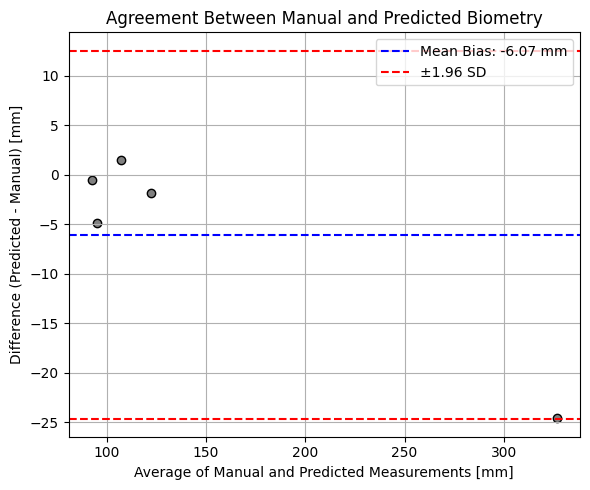

{'MAE [mm]': np.float64(6.66), 'RMSE [mm]': np.float64(11.27), 'Mean Relative Error [%]': np.float64(3.13), 'Pearson r': np.float64(1.0)}


In [305]:
biometry_metrics_summary = analyze_patient_biometry_errors(df_biometry)
print(biometry_metrics_summary)


## 4️⃣ Calculating Pelvis Biometry 🌟

In [306]:
import numpy as np
import nibabel as nib
#pip install scikit-image

### Old pelvimetry function

In [23]:
def compute_pelvimetry(landmarks_path):
    # Load the landmarks NIfTI file
    landmarks_img = nib.load(landmarks_path)
    landmarks_data = landmarks_img.get_fdata()

    # Extract the affine transformation matrix
    affine = landmarks_img.affine  # 4x4 matrix mapping voxel -> mm

    # Find the centroid coordinates of each landmark in voxel space
    landmark_indices = {}
    for i in range(10, 21):  # Landmark labels are from 10 to 20
        coords = np.argwhere(landmarks_data == i)
        if coords.size > 0:
            centroid_voxel = coords.mean(axis=0)  # Compute centroid in voxel space

            # Convert voxel coordinates to real-world mm using affine transformation
            centroid_mm = np.append(centroid_voxel, 1)  # Convert to homogeneous coordinates
            real_world_mm = np.dot(affine, centroid_mm)[:3]  # Apply transformation

            landmark_indices[i] = real_world_mm  # Store mm coordinates

    # Define the landmark pairs and their names
    distances_to_compute = {
        "Inlet transverse diameter": (18, 19),
        "Interspines distance": (15, 16),
        "Intertuburious distance": (10, 11),
        "Obstetric conjugate": (13, 20),
        "Midpelvis AP diameter": (12, 17),
        "Inlet AP diameter": (14, 20)
    }

    # Compute Euclidean distances in real-world mm
    distances = {}
    for name, (lm1, lm2) in distances_to_compute.items():
        if lm1 in landmark_indices and lm2 in landmark_indices:
            dist = np.linalg.norm(landmark_indices[lm1] - landmark_indices[lm2])
            distances[name] = dist
        else:
            distances[name] = None  # Handle missing landmarks

    # Print the distances
    for name, dist in distances.items():
        if dist is not None:
            print(f"{name}: {dist:.2f} mm")
        else:
            print(f"{name}: Landmark(s) missing")

    return distances

In [25]:
# Calculating the distance between the landmarks segemnted by the model
landmarks_path = pelvis_output_lab_name
pelvimetry_results = compute_pelvimetry(landmarks_path)
pelvimetry_results

Inlet transverse diameter: 140.76 mm
Interspines distance: 126.70 mm
Intertuburious distance: 115.52 mm
Obstetric conjugate: 143.83 mm
Midpelvis AP diameter: 122.85 mm
Inlet AP diameter: 142.77 mm


{'Inlet transverse diameter': np.float64(140.76390892200286),
 'Interspines distance': np.float64(126.70302538619475),
 'Intertuburious distance': np.float64(115.52263252826226),
 'Obstetric conjugate': np.float64(143.8280827836996),
 'Midpelvis AP diameter': np.float64(122.84620999099182),
 'Inlet AP diameter': np.float64(142.77101570772186)}

### New Pelvimetry Function

In [345]:
import numpy as np
import nibabel as nib

def compute_pelvimetry(landmarks_path):
    # Load the landmarks NIfTI file
    landmarks_img = nib.load(landmarks_path)
    landmarks_data = landmarks_img.get_fdata()

    # Extract the affine transformation matrix
    affine = landmarks_img.affine  # 4x4 matrix mapping voxel -> mm

    # Find the centroid coordinates of each landmark in voxel space
    landmark_indices = {}
    for i in range(10, 21):  # Landmark labels are from 10 to 20
        coords = np.argwhere(landmarks_data == i)
        if coords.size > 0:
            centroid_voxel = coords.mean(axis=0)  # Compute centroid in voxel space

            # Convert voxel coordinates to real-world mm using affine transformation
            centroid_mm = np.append(centroid_voxel, 1)  # Convert to homogeneous coordinates
            real_world_mm = np.dot(affine, centroid_mm)[:3]  # Apply transformation

            landmark_indices[i] = real_world_mm  # Store mm coordinates

    # Define the landmark pairs and their names
    distances_to_compute = {
        "Inlet transverse diameter": (18, 19),
        "Interspines distance": (15, 16),
        "Intertuburious distance": (10, 11),
        "Obstetric conjugate": (13, 20),
        "Midpelvis AP diameter": (12, 17),
        "Inlet AP diameter": (14, 20)
    }

    # Compute Euclidean distances in real-world mm
    distances = {}
    for name, (lm1, lm2) in distances_to_compute.items():
        if lm1 in landmark_indices and lm2 in landmark_indices:
            dist = np.linalg.norm(landmark_indices[lm1] - landmark_indices[lm2])
            distances[name] = dist
        else:
            distances[name] = None  # Handle missing landmarks

    # Calculate additional circumferences if necessary distances are available
    if distances["Inlet AP diameter"] is not None and distances["Inlet transverse diameter"] is not None:
        inlet_circumference = (distances["Inlet AP diameter"] + distances["Inlet transverse diameter"]) * (np.pi / 2)
        distances["Pelvic inlet circumference"] = inlet_circumference
    else:
        distances["Pelvic inlet circumference"] = None

    if distances["Midpelvis AP diameter"] is not None and distances["Interspines distance"] is not None:
        midpelvis_circumference = (distances["Midpelvis AP diameter"] + distances["Interspines distance"]) * (np.pi / 2)
        distances["Mid pelvis circumference"] = midpelvis_circumference
    else:
        distances["Mid pelvis circumference"] = None

    # Print the distances
    for name, dist in distances.items():
        if dist is not None:
            print(f"{name}: {dist:.2f} mm")
        else:
            print(f"{name}: Landmark(s) missing")

    return distances


In [347]:
# Calculating the distance between the landmarks segemnted by the model
landmarks_path = pelvis_output_lab_name
pelvimetry_results = compute_pelvimetry(landmarks_path)
pelvimetry_results

Inlet transverse diameter: 129.97 mm
Interspines distance: 133.13 mm
Intertuburious distance: 127.39 mm
Obstetric conjugate: 128.01 mm
Midpelvis AP diameter: 114.15 mm
Inlet AP diameter: 127.78 mm
Pelvic inlet circumference: 404.87 mm
Mid pelvis circumference: 388.42 mm


{'Inlet transverse diameter': np.float64(129.97143313574927),
 'Interspines distance': np.float64(133.12716797397871),
 'Intertuburious distance': np.float64(127.39246633745347),
 'Obstetric conjugate': np.float64(128.0089540009043),
 'Midpelvis AP diameter': np.float64(114.14565743631329),
 'Inlet AP diameter': np.float64(127.7785897056329),
 'Pelvic inlet circumference': np.float64(404.87278911054375),
 'Mid pelvis circumference': np.float64(388.41524587068244)}

In [348]:
#biometry_results = compute_fetal_biometry("fetal_landmarks.nii.gz")

manual_pelvis_values = {
    "Inlet transverse diameter": 131.7,
    "Interspines distance": 133.2,
    "Intertuburious distance": 124.3,
    "Obstetric conjugate": 133.6,
    "Midpelvis AP diameter": 120,
    "Inlet AP diameter": 130.9,
    "Pelvic inlet circumference": 402.3,
    "Mid pelvis circumference": 377.7
}

df_pelvimetry = biometry_dict_to_dataframe(pelvimetry_results, manual_pelvis_values)
df_pelvimetry

,Measurements,UNet Predicted [mm],Manual [mm]
0,Inlet transverse diameter,129.971433,131.7
1,Interspines distance,133.127168,133.2
2,Intertuburious distance,127.392466,124.3
3,Obstetric conjugate,128.008954,133.6
4,Midpelvis AP diameter,114.145657,120.0
5,Inlet AP diameter,127.778590,130.9
6,Pelvic inlet circumference,404.872789,402.3
7,Mid pelvis circumference,388.415246,377.7


In [349]:
df_pelvimetry = add_error_metrics(df_pelvimetry)
df_pelvimetry

,Measurements,UNet Predicted [mm],Manual [mm],MAE [mm],Relative Error [%]
0,Inlet transverse diameter,129.971433,131.7,1.728567,1.312503
1,Interspines distance,133.127168,133.2,0.072832,0.054679
2,Intertuburious distance,127.392466,124.3,3.092466,2.487905
3,Obstetric conjugate,128.008954,133.6,5.591046,4.184915
4,Midpelvis AP diameter,114.145657,120.0,5.854343,4.878619
5,Inlet AP diameter,127.778590,130.9,3.121410,2.384576
6,Pelvic inlet circumference,404.872789,402.3,2.572789,0.639520
7,Mid pelvis circumference,388.415246,377.7,10.715246,2.836973


In [350]:
# Create output directory
res_dir = root_dir + "/" + "Pelvimetry_results_new"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)

out_csv_path = 'Pelvimetry_results_new/pelvimetry_' + subject + '.csv'

# Save the DataFrame
df_pelvimetry.to_csv(out_csv_path, index=False)

print(f"Saved results to: {out_csv_path}")

Saved results to: Pelvimetry_results_new/pelvimetry_mibirth018701.csv


===== Biometry Evaluation Metrics (from DataFrame) =====
MAE: 4.46 mm
RMSE: 6.88 mm
Mean Relative Error: 2.02 %
Pearson Correlation (r): 0.999


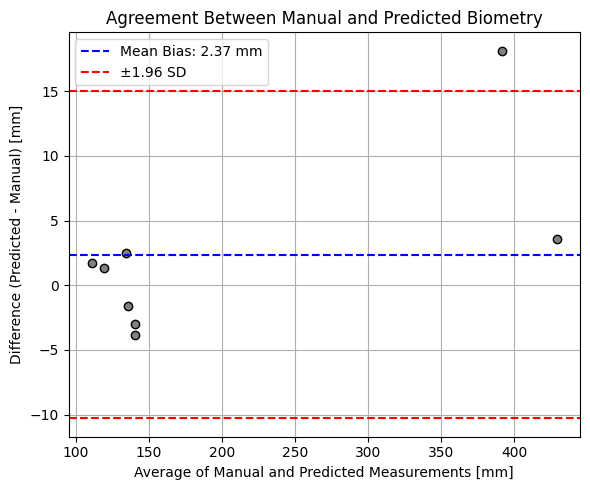

{'MAE [mm]': np.float64(4.46), 'RMSE [mm]': np.float64(6.88), 'Mean Relative Error [%]': np.float64(2.02), 'Pearson r': np.float64(0.999)}


In [312]:
pelvimetry_metrics_summary = analyze_patient_biometry_errors(df_pelvimetry)
print(pelvimetry_metrics_summary)


## 4️⃣ Relative-Position Measurements 🐣

**calculate_head_engagement**: Calculates fetal head engagement: perpendicular distance from head center (label 10) to inlet plane (labels 14, 18, 19, 20), and maps it to an estimated fetal station score.


In [141]:
import numpy as np
import nibabel as nib

def calculate_head_engagement(fetal_landmarks_path, pelvic_landmarks_path):

    # Load fetal data and extract label 10 (head center)
    fetal_img = nib.load(fetal_landmarks_path)
    fetal_data = fetal_img.get_fdata()
    fetal_affine = fetal_img.affine

    coords_fetal = np.argwhere(fetal_data == 10)
    if coords_fetal.size == 0:
        print("Missing fetal head center (label 10)")
        return None
    head_centroid_voxel = coords_fetal.mean(axis=0)
    head_center_mm = np.dot(fetal_affine, np.append(head_centroid_voxel, 1))[:3]

    # Load pelvic data and extract inlet landmarks
    pelvic_img = nib.load(pelvic_landmarks_path)
    pelvic_data = pelvic_img.get_fdata()
    pelvic_affine = pelvic_img.affine

    inlet_labels = {
        14: "Pubic symphysis (superior)",
        18: "Iliopubic line (R)",
        19: "Iliopubic line (L)",
        20: "Sacral promontory"
    }

    inlet_coords_mm = []
    for label, name in inlet_labels.items():
        coords = np.argwhere(pelvic_data == label)
        if coords.size == 0:
            print(f"Missing pelvic landmark {label}: {name}")
            return None
        centroid_voxel = coords.mean(axis=0)
        centroid_mm = np.dot(pelvic_affine, np.append(centroid_voxel, 1))[:3]
        inlet_coords_mm.append(centroid_mm)

    # Fit best-fit inlet plane (via SVD)
    inlet_points = np.vstack(inlet_coords_mm)
    plane_centroid = inlet_points.mean(axis=0)
    _, _, vh = np.linalg.svd(inlet_points - plane_centroid)
    inlet_normal = vh[-1]

    # Compute signed distance from head center to inlet plane
    vector_to_head = head_center_mm - plane_centroid
    signed_distance = np.dot(vector_to_head, inlet_normal)

    # Map distance to station score
    def estimate_station(distance_mm):
        thresholds = [-50, -40, -30, -20, -10, 10, 20, 30, 40, 50]
        scores = [5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5]
        for i, threshold in enumerate(thresholds):
            if distance_mm < threshold:
                return scores[i]
        return scores[-1]  # For very large distances above inlet

    station_score = estimate_station(signed_distance)

    return {
        "engagement_mm": round(signed_distance, 2),
        "station_score": station_score
    }


In [142]:
# dir = '/content/drive/MyDrive/BEng_Project2/NEW/running-pelvis-and-fetus-landmarks/UNet_testing_results'
# pelvic_landmarks_path = dir + '/resampled_' + subject + '-t2.nii.gz'
# fetal_landmarks_path = dir + '/resampled_' + subject + '-t2-fetus_labels.nii.gz'

pelvic_landmarks_path = pelvis_output_lab_name
fetal_landmarks_path = fetus_output_lab_name

engagement_result = calculate_head_engagement(fetal_landmarks_path, pelvic_landmarks_path)

if engagement_result:
    print(f"Head engagement: {engagement_result['engagement_mm']} mm")
    print(f"Estimated fetal station: {engagement_result['station_score']}")


Head engagement: 22.06 mm
Estimated fetal station: -2


### old relative pose metric calculations:

**calculate_hc_oc_and_magnin_index**: Calculates the HC/OC ratio and the Magnin Index from two distance dictionaries:Output from compute_pelvimetry() and Output from compute_fetal_biometry()


In [353]:
def calculate_hc_oc_and_magnin_index(pelvimetry_distances, fetal_biometry_distances):

    hc = fetal_biometry_distances.get("Fetal head circumference (HC)")
    oc = pelvimetry_distances.get("Obstetric conjugate")
    interspines = pelvimetry_distances.get("Interspines distance")

    results = {}

    # HC/OC Ratio
    if hc is not None and oc is not None and oc != 0:
        results["HC/OC ratio"] = round(hc / oc, 3)
    else:
        results["HC/OC ratio"] = None

    # Magnin Index
    if oc is not None and interspines is not None:
        results["Magnin Index [mm]"] = round(oc + interspines, 2)
    else:
        results["Magnin Index [mm]"] = None

    return results


In [354]:

metrics = calculate_hc_oc_and_magnin_index(pelvimetry_results, biometry_results)

metrics


{'HC/OC ratio': None, 'Magnin Index [mm]': np.float64(261.14)}

**calculate_summary_metrics_from_csvs**: Loads fetal biometry and pelvimetry CSVs, extracts necessary values, and calculates HC/OC, Magnin Index, HC-IC, HC-MC, and FPI. Returns a dictionary of the computed metrics

In [54]:
import pandas as pd

def calculate_summary_metrics_from_csvs(biometry_csv_path, pelvimetry_csv_path):

    # Load CSVs
    df_bio = pd.read_csv(biometry_csv_path)
    df_pelvis = pd.read_csv(pelvimetry_csv_path)

    # Extract values from first row (assuming one subject per file)
    hc = df_bio.get("Fetal head circumference (HC)", [None])[0]
    oc = df_pelvis.get("Obstetric conjugate", [None])[0]
    interspines = df_pelvis.get("Interspines distance", [None])[0]
    inlet_circ = df_pelvis.get("Pelvic inlet circumference", [None])[0]
    midpelvis_circ = df_pelvis.get("Mid pelvis circumference", [None])[0]

    results = {}

    # HC/OC Ratio
    if hc is not None and oc is not None and oc != 0:
        results["HC/OC ratio"] = round(hc / oc, 3)
    else:
        results["HC/OC ratio"] = None

    # Magnin Index
    if oc is not None and interspines is not None:
        magnin = oc + interspines
        results["Magnin Index [mm]"] = round(magnin, 2)
    else:
        results["Magnin Index [mm]"] = None

    # HC - Inlet Circumference
    if hc is not None and inlet_circ is not None:
        hc_ic = hc - inlet_circ
        results["HC - Inlet Circumference (HC-IC)"] = round(hc_ic, 2)
    else:
        hc_ic = None
        results["HC - Inlet Circumference (HC-IC)"] = None

    # HC - Midpelvis Circumference
    if hc is not None and midpelvis_circ is not None:
        hc_mc = hc - midpelvis_circ
        results["HC - Midpelvis Circumference (HC-MC)"] = round(hc_mc, 2)
    else:
        hc_mc = None
        results["HC - Midpelvis Circumference (HC-MC)"] = None

    # FPI: sum of the two most positive differences
    diff_list = [d for d in [hc_ic, hc_mc] if d is not None]
    if len(diff_list) >= 2:
        top_two = sorted(diff_list, reverse=True)[:2]
        fpi = top_two[0] + top_two[1]
        results["Fetal Pelvic Index (FPI)"] = round(fpi, 2)
    else:
        results["Fetal Pelvic Index (FPI)"] = None

    return results


### new relative pose metric calculations:

**calculate_summary_metrics_from_long_csvs**: Calculates the HC/OC ratio and the Magnin Index from two distance dictionaries:Output from compute_pelvimetry() and Output from compute_fetal_biometry()

In [143]:
import pandas as pd

def calculate_summary_metrics_from_long_csvs(biometry_csv_path, pelvimetry_csv_path):

    # Load both CSVs
    df_bio = pd.read_csv(biometry_csv_path)
    df_pelvis = pd.read_csv(pelvimetry_csv_path)

    # Set 'Measurements' as the index for row-based lookup
    df_bio.set_index("Measurements", inplace=True)
    df_pelvis.set_index("Measurements", inplace=True)

    # Extract needed values from the 'UNet Predicted [mm]' column
    def get_val(df, label):
        try:
            return float(df.loc[label, "UNet Predicted [mm]"])
        except KeyError:
            print(f"Missing measurement: {label}")
            return None

    hc = get_val(df_bio, "Fetal head circumference (HC)")
    oc = get_val(df_pelvis, "Obstetric conjugate")
    interspines = get_val(df_pelvis, "Interspines distance")
    inlet_circ = get_val(df_pelvis, "Pelvic inlet circumference")
    midpelvis_circ = get_val(df_pelvis, "Mid pelvis circumference")

    results = {}

    # HC/OC Ratio
    if hc is not None and oc is not None and oc != 0:
        results["HC/OC ratio"] = round(hc / oc, 3)
    else:
        results["HC/OC ratio"] = None

    # Magnin Index
    if oc is not None and interspines is not None:
        magnin = oc + interspines
        results["Magnin Index [mm]"] = round(magnin, 2)
    else:
        results["Magnin Index [mm]"] = None

    # HC - Inlet Circumference
    if hc is not None and inlet_circ is not None:
        hc_ic = hc - inlet_circ
        results["HC - Inlet Circumference (HC-IC)"] = round(hc_ic, 2)
    else:
        hc_ic = None
        results["HC - Inlet Circumference (HC-IC)"] = None

    # HC - Midpelvis Circumference
    if hc is not None and midpelvis_circ is not None:
        hc_mc = hc - midpelvis_circ
        results["HC - Midpelvis Circumference (HC-MC)"] = round(hc_mc, 2)
    else:
        hc_mc = None
        results["HC - Midpelvis Circumference (HC-MC)"] = None

    # FPI = sum of 2 most positive differences
    diff_list = [d for d in [hc_ic, hc_mc] if d is not None]
    if len(diff_list) >= 2:
        top_two = sorted(diff_list, reverse=True)[:2]
        results["Fetal Pelvic Index (FPI)"] = round(sum(top_two), 2)
    else:
        results["Fetal Pelvic Index (FPI)"] = None

    return results



In [144]:
metrics = calculate_summary_metrics_from_long_csvs(
    biometry_csv_path="/content/drive/MyDrive/BEng_Project2/NEW/running-pelvis-and-fetus-landmarks/Fetal_biometry_results_new/fetal_biometry_" + subject + ".csv",
    pelvimetry_csv_path="/content/drive/MyDrive/BEng_Project2/NEW/running-pelvis-and-fetus-landmarks/Pelvimetry_results_new/pelvimetry_" + subject + ".csv"
)

print(metrics)


{'HC/OC ratio': nan, 'Magnin Index [mm]': 253.61, 'HC - Inlet Circumference (HC-IC)': nan, 'HC - Midpelvis Circumference (HC-MC)': nan, 'Fetal Pelvic Index (FPI)': nan}


**compile_relative_position_metrics_to_df:** Combines fetal head engagement and HC/OC + Magnin Index metrics into a single DataFrame


In [145]:
import pandas as pd

def compile_relative_position_metrics_to_df(engagement_result, metric_result):

    combined = {
        "Subject": subject,
        "Head Engagement (mm)": engagement_result.get("engagement_mm") if engagement_result else None,
        "Estimated Station": engagement_result.get("station_score") if engagement_result else None,
        "HC/OC Ratio": metric_result.get("HC/OC ratio") if metric_result else None,
        "Magnin Index (mm)": metric_result.get("Magnin Index [mm]") if metric_result else None,
        "HC-IC (mm)": metric_result.get("HC - Inlet Circumference (HC-IC)") if metric_result else None,
        "HC-MC (mm)": metric_result.get("HC - Midpelvis Circumference (HC-MC)") if metric_result else None,
        "FPI": metric_result.get("Fetal Pelvic Index (FPI)") if metric_result else None
    }

    return pd.DataFrame([combined])


In [146]:

# Combine into a DataFrame:
relative_summary_df = compile_relative_position_metrics_to_df(engagement_result, metrics)
relative_summary_df

,Subject,Head Engagement (mm),Estimated Station,HC/OC Ratio,Magnin Index (mm),HC-IC (mm),HC-MC (mm),FPI
0,mibirth019301,22.06,-2,NaN,253.61,NaN,NaN,NaN


In [150]:
# Create output directory
res_dir = root_dir + "/" + "Relative_measurements_results_new"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)

out_csv_path = 'Relative_measurements_results_new/Relative_measurements_' + subject + '.csv'

# Save the DataFrame
relative_summary_df.to_csv(out_csv_path, index=False)

print(f"Saved results to: {out_csv_path}")

Saved results to: Relative_measurements_results_new/Relative_measurements_mibirth019301.csv


## Merge All Subject CSVs into One 🧺


In [147]:
import pandas as pd
import glob
import os
import re

def merge_subject_csvs(folder_path):
    """
    Merge all per-subject biometry CSVs into one DataFrame, with subject ID extracted from filenames.

    Args:
        folder_path (str): path to the folder containing all subject CSVs

    Returns:
        merged_df (pd.DataFrame): combined DataFrame with a 'Subject' column
    """
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    df_list = []

    for file in all_files:
        # Extract subject ID using regex: gets "mibirth019001" from the filename
        match = re.search(r"mibirth\d+", os.path.basename(file))
        subject_id = match.group(0) if match else "unknown"

        df = pd.read_csv(file)
        df.insert(0, "Subject", subject_id)  # Insert 'Subject' as the first column
        df_list.append(df)

    merged_df = pd.concat(df_list, ignore_index=True)
    print(f"✅ Merged {len(df_list)} subject files.")
    return merged_df


In [359]:
merged_pelvimetry_df = merge_subject_csvs("/content/drive/MyDrive/BEng_Project2/NEW/running-pelvis-and-fetus-landmarks/Pelvimetry_results_new")
merged_pelvimetry_df.head()


✅ Merged 5 subject files.


,Subject,Measurements,UNet Predicted [mm],Manual [mm],MAE [mm],Relative Error [%]
0,mibirth019001,Inlet transverse diameter,137.641093,142.1,4.458907,3.137866
1,mibirth019001,Interspines distance,125.781413,128.7,2.918587,2.267744
2,mibirth019001,Intertuburious distance,116.157257,118.9,2.742743,2.306765
3,mibirth019001,Obstetric conjugate,139.808239,138.4,1.408239,1.017513
4,mibirth019001,Midpelvis AP diameter,127.650245,130.7,3.049755,2.333401


In [360]:
merged_biometry_df = merge_subject_csvs("/content/drive/MyDrive/BEng_Project2/NEW/running-pelvis-and-fetus-landmarks/Fetal_biometry_results_new")
merged_biometry_df.head()


✅ Merged 5 subject files.


,Subject,Measurements,UNet Predicted [mm],Manual [mm],MAE [mm],Relative Error [%]
0,mibirth019001,OFD,105.625358,105.30,0.325358,0.308982
1,mibirth019001,Mento-vertical diameter,124.574097,125.10,0.525903,0.420386
2,mibirth019001,BPD,89.621107,90.75,1.128893,1.243959
3,mibirth019001,Bihumeral diameter,85.297199,82.15,3.147199,3.831039
4,mibirth019001,Fetal head circumference (HC),306.692430,318.80,12.107570,3.797858


In [361]:
merged_biometry_df

,Subject,Measurements,UNet Predicted [mm],Manual [mm],MAE [mm],Relative Error [%]
0,mibirth019001,OFD,105.625358,105.30,0.325358,0.308982
1,mibirth019001,Mento-vertical diameter,124.574097,125.10,0.525903,0.420386
2,mibirth019001,BPD,89.621107,90.75,1.128893,1.243959
3,mibirth019001,Bihumeral diameter,85.297199,82.15,3.147199,3.831039
4,mibirth019001,Fetal head circumference (HC),306.692430,318.80,12.107570,3.797858
5,mibirth018901,OFD,112.706328,111.50,1.206328,1.081908
6,mibirth018901,Mento-vertical diameter,132.899883,137.10,4.200117,3.063543
7,mibirth018901,BPD,94.251785,96.09,1.838215,1.913014
8,mibirth018901,Bihumeral diameter,91.495402,92.09,0.594598,0.645671
9,mibirth018901,Fetal head circumference (HC),325.089043,347.60,22.510957,6.476110


## Evaluation Across all Subjects 📊

In [407]:
def plot_mean_mae_per_measurement_plotly(df, error_type="MAE [mm]", color_map=None, measurement_order=None, measurement_type="Fetal Biometry"):


    # mean_mae_df = df.groupby("Measurements", as_index=False)["MAE [mm]"].mean()
    # mean_mae_df["Color"] = mean_mae_df["Measurements"].map(color_map)

    mean_error_df = df.groupby("Measurements", as_index=False)[error_type].mean()  # Changed to use error_type
    mean_error_df["Color"] = mean_error_df["Measurements"].map(color_map)

    fig = px.bar(
        mean_error_df,
        x="Measurements",
        y=error_type,
        category_orders={"Measurement": measurement_order},
        color="Measurements",
        color_discrete_map=color_map,
        title=f"Average {error_type} per {measurement_type} Measurement"
    )

    fig.update_layout(
        xaxis_tickangle=-45,
        showlegend=False,
        height=500,
        width=700,
        margin=dict(t=50, b=80),
        template="simple_white"
    )
    fig.show()


In [408]:
def plot_error_distribution_boxplot_plotly(df, error_type="MAE [mm]", color_map=None, measurement_order=None, measurement_type="Fetal Biometry"):
    fig = px.box(
        df,
        x="Measurements",
        y=error_type,
        category_orders={"Measurement": measurement_order},
        color="Measurements",
        color_discrete_map=color_map,
        points="all",
        title=f"{error_type} Distribution per {measurement_type} Measurement Across Subjects"
    )

    fig.update_layout(
        xaxis_tickangle=-45,
        showlegend=False,
        height=500,
        width=700,
        margin=dict(t=50, b=80),
        template="simple_white",
        yaxis=dict( showgrid=True, gridwidth=1, gridcolor='lightgrey'),
        xaxis=dict(showgrid=True,gridwidth=1,gridcolor='lightgrey')
    )
    fig.show()


In [409]:
!pip install plotly
import plotly.express as px

# Step 1: consistent order + color map
measurement_order = list(merged_pelvimetry_df["Measurements"].unique())  # or sorted(...)
color_palette = px.colors.qualitative.Set2
color_map = {m: color_palette[i % len(color_palette)] for i, m in enumerate(measurement_order)}

# Step 2: plots
plot_mean_mae_per_measurement_plotly(merged_pelvimetry_df, "MAE [mm]", color_map, measurement_order, "Pelvimetry")
plot_error_distribution_boxplot_plotly(merged_pelvimetry_df, "MAE [mm]", color_map, measurement_order,  "Pelvimetry")
#plot_error_distribution_boxplot_plotly(merged_df, "Relative Error [%]", color_map, measurement_order)


In [410]:
!pip install plotly
import plotly.express as px

# Step 1: consistent order + color map
measurement_order = list(merged_biometry_df["Measurements"].unique())  # or sorted(...)
color_palette = px.colors.qualitative.Set2
color_map = {m: color_palette[i % len(color_palette)] for i, m in enumerate(measurement_order)}

# Step 2: plots
plot_mean_mae_per_measurement_plotly(merged_biometry_df, "MAE [mm]", color_map, measurement_order)
plot_error_distribution_boxplot_plotly(merged_biometry_df, "MAE [mm]", color_map, measurement_order)
#plot_error_distribution_boxplot_plotly(merged_df, "Relative Error [%]", color_map, measurement_order)


In [411]:
!pip install plotly
import plotly.express as px

# Step 1: consistent order + color map
measurement_order = list(merged_pelvimetry_df["Measurements"].unique())  # or sorted(...)
color_palette = px.colors.qualitative.Set2
color_map = {m: color_palette[i % len(color_palette)] for i, m in enumerate(measurement_order)}

# Step 2: plots
plot_mean_mae_per_measurement_plotly(merged_pelvimetry_df, "Relative Error [%]", color_map, measurement_order, "Pelvimetry")
plot_error_distribution_boxplot_plotly(merged_pelvimetry_df, "Relative Error [%]", color_map, measurement_order, "Pelvimetry")
#plot_error_distribution_boxplot_plotly(merged_df, "Relative Error [%]", color_map, measurement_order)


In [412]:
!pip install plotly
import plotly.express as px

# Step 1: consistent order + color map
measurement_order = list(merged_biometry_df["Measurements"].unique())  # or sorted(...)
color_palette = px.colors.qualitative.Set2
color_map = {m: color_palette[i % len(color_palette)] for i, m in enumerate(measurement_order)}

# Step 2: plots
plot_mean_mae_per_measurement_plotly(merged_biometry_df, "Relative Error [%]", color_map, measurement_order)
plot_error_distribution_boxplot_plotly(merged_biometry_df, "Relative Error [%]", color_map, measurement_order)
#plot_error_distribution_boxplot_plotly(merged_df, "Relative Error [%]", color_map, measurement_order)

**load_and_concatenate_summary_csvs**: Loads all CSV files in a folder, concatenates them into a single DataFrame, and sorts by 'Subject' column in ascending order.

In [148]:
import pandas as pd
import os
from glob import glob

def load_and_concatenate_summary_csvs(folder_path):

    # Find all CSV files
    csv_files = glob(os.path.join(folder_path, "*.csv"))

    if not csv_files:
        print("No CSV files found in the folder.")
        return None

    # Load and concatenate
    dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        dfs.append(df)

    concatenated_df = pd.concat(dfs, ignore_index=True)

    # Sort by the 'Subject' column
    if "Subject" in concatenated_df.columns:
        concatenated_df = concatenated_df.sort_values(by="Subject").reset_index(drop=True)
    else:
        print("Warning: 'Subject' column not found. Returning unsorted DataFrame.")

    return concatenated_df


In [151]:
merged_relativepos_df = load_and_concatenate_summary_csvs("/content/drive/MyDrive/BEng_Project2/NEW/running-pelvis-and-fetus-landmarks/Relative_measurements_results_new")
merged_relativepos_df.head()

,Subject,Head Engagement (mm),Estimated Station,HC/OC Ratio,Magnin Index (mm),HC-IC (mm),HC-MC (mm),FPI
0,mibirth018701,32.90,-3,NaN,NaN,NaN,NaN,NaN
1,mibirth018901,32.69,-3,2.260,270.53,-120.29,-66.90,-187.19
2,mibirth019001,15.01,-1,2.194,265.59,-122.07,-91.40,-213.47
3,mibirth019201,28.90,-2,2.265,258.87,-116.52,-86.14,-202.66
4,mibirth019301,22.06,-2,NaN,253.61,NaN,NaN,NaN
